In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.basic_data import *
from skimage.util import montage
import pandas as pd
from torch import optim
import re
import json
import cv2
import albumentations
from fastai.callbacks.hooks import num_features_model
from torch.nn import L1Loss

from utils import *

In [2]:
from motion.detect_human import BBoxDataset

I used [sloth](https://github.com/cvhciKIT/sloth) to annotate the images.

You can find the config file in the `data` folder (`sloth_config.py`). The command to start `sloth` that I used was: `sloth --config sloth_config.py annotations.json`. I ran the command from within the directory where I stored my train images (both the `sloth_config.py` and `annotations.json` files were inside the directory as well).

In [3]:
SZ = 500

In [4]:
# https://github.com/albu/albumentations/blob/master/notebooks/example_bboxes.ipynb
def visualize(sample):
    
    return plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(255, 0, 0),3)
    return img
    

In [5]:
# trn_ds = BBoxDataset("coco/train2017_one_human.csv", size = SZ, type = "train")
trn_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "train")
# val_ds = BBoxDataset("coco/val2017_one_human_train.csv", size = SZ, type = "valid")
val_ds = BBoxDataset("coco/val2017_one_human_val.csv", size = SZ, type = "valid")
# val_ds = BBoxDataset("motion/detect_human/one_sample_dataset.csv", size = SZ, type = "valid")
val_ds[0][0].mean()

Dataset has 925 samples.
Dataset has 225 samples.


-0.011952356

In [6]:
NUM_WORKERS=5
BS = 64

train_dl = DataLoader(trn_ds, BS, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
valid_dl = DataLoader(val_ds, BS, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

data_bunch = DataBunch(train_dl, valid_dl)

In [7]:
from motion.detect_human import HumanBBox

In [8]:
def intersection(preds, targs):
    # preds and targs are of shape (bs, 4), pascal_voc format
    max_xy = torch.min(preds[:, 2:], targs[:, 2:])
    min_xy = torch.max(preds[:, :2], targs[:, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, 0] * inter[:, 1]

def area(boxes): 
    return ((boxes[:, 2]-boxes[:, 0]) * (boxes[:, 3]-boxes[:, 1]))

def union(preds, targs):
    return area(preds) + area(targs) - intersection(preds, targs)

def IoU(preds, targs):
    return intersection(preds, targs) / union(preds, targs)

In [9]:
def l1(preds, targs):
    return L1Loss()(preds, targs).mean()
def iou_loss(preds, targs):
    return 1.0-IoU(preds, targs).mean()

def iou_custom_loss(preds, targs):
    loss = iou_loss(preds,targs)
    l1_loss = l1(preds,targs)
    loss += l1_loss
    return loss*100

In [10]:
learn = Learner(data_bunch, HumanBBox(ap_sz = 16), loss_func=iou_loss)
learn.metrics = [l1,iou_loss ]

In [11]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,l1,iou_loss
1,0.654436,0.667645,0.182718,0.667645
2,0.649500,0.680558,0.181705,0.680558
3,0.656245,0.693751,0.201258,0.693751
4,0.655156,0.694013,0.210098,0.694013
5,0.656394,0.678958,0.198040,0.678958
6,0.654177,0.697457,0.174695,0.697457
7,0.654535,0.683425,0.195749,0.683425
8,0.653676,0.672741,0.184117,0.672741
9,0.650787,0.662111,0.180258,0.662111


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.validate()

In [15]:
learn.save('fastai_bbox_detect_humans_res18_arch_loss_sz16_extr_conv_1')

In [18]:
preds, targs = learn.get_preds()

Let's take a look at the results.

In [19]:
predicted_bboxes = ((preds) * SZ).numpy()
targets = ((targs) * SZ).numpy()
predicted_bboxes

array([[ 68.50388 ,  74.82815 , 453.4861  , 469.86053 ],
       [ 83.349464,  72.16303 , 396.8389  , 448.3735  ],
       [101.337105,  38.55136 , 344.8335  , 386.06277 ],
       [ 58.77967 ,  34.455303, 465.26917 , 472.9905  ],
       ...,
       [ 87.33502 ,  28.156582, 409.28763 , 456.06253 ],
       [ 51.952667,  34.38436 , 439.6936  , 473.3103  ],
       [ 58.805946,  34.559784, 471.93845 , 485.91162 ],
       [ 29.234428, 155.07733 , 287.42676 , 493.65176 ]], dtype=float32)

In [20]:
targs*SZ

tensor([[274.0000, 118.0000, 401.0000, 434.0000],
        [115.0000, 295.0000, 160.0000, 422.0000],
        [238.0000,  88.0000, 354.0000, 291.0000],
        [ 50.0000, 112.0000, 413.0000, 350.0000],
        [136.0000,  42.0000, 494.0000, 455.0000],
        [140.0000,  46.0000, 311.0000, 384.0000],
        [ 65.0000, 160.0000, 210.0000, 441.0000],
        [166.0000,  51.0000, 322.0000, 489.0000],
        [399.0000, 163.0000, 465.0000, 327.0000],
        [162.0000,  19.0000, 336.0000, 245.0000],
        [267.0000, 239.0000, 405.0000, 347.0000],
        [ 79.0000,  70.0000, 299.0000, 373.0000],
        [139.0000,  74.0000, 296.0000, 348.0000],
        [ 10.0000,  17.0000, 168.0000, 301.0000],
        [  0.0000,  43.0000, 250.0000, 452.0000],
        [198.0000,  54.0000, 428.0000, 495.0000],
        [208.0000, 103.0000, 450.0000, 410.0000],
        [113.0000, 171.0000, 232.0000, 350.0000],
        [ 43.0000, 189.0000,  87.0000, 353.0000],
        [ 56.0000, 200.0000, 224.0000, 376.0000],


In [21]:
def draw_bbox(img, bbox, target=None, color= (255, 0, 0), thickness=2):
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), 255, 3)
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(0,255,0), thickness=3)
    return img

def visualize(sample, target = None):
    
    im = plot_im(sample[0].transpose(1, 2, 0).astype(np.uint8), sample[1])
    if target is not None:
        x_min, y_min, x_max, y_max = map(int, target)
        cv2.rectangle(im, (x_min, y_min), (x_max, y_max), color=(255,0,0), thickness=3)
    return im
    

def plot_im(img,bbox):
    x_min, y_min, x_max, y_max = map(int, bbox*SZ)
    print(img.shape)
    img = cv2.rectangle(img, (x_min, y_min), (x_max,y_max),(0, 255, 0),3)
    return img


(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)
(500, 500, 3)


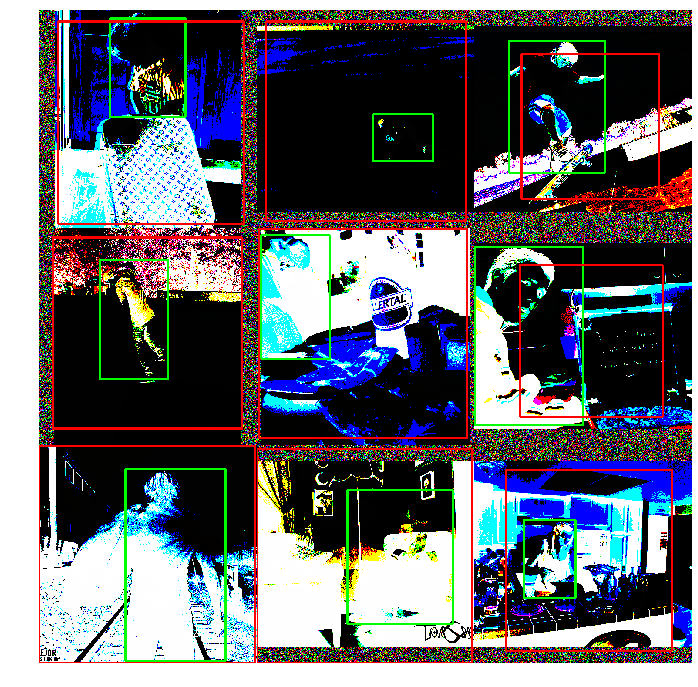

In [22]:
ims = np.stack([visualize(val_ds[i],target= predicted_bboxes[i]) for i in range(9,18)])
# ims = visualize(val_ds[0],target= predicted_bboxes[0])
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(montage(np.stack(ims), multichannel=True))
# plt.imshow(np.stack(ims))